# Notebook 04: Baseline Linear Models

## Objective
Train simple linear baselines (Linear Regression, Ridge, Lasso) to establish performance floor using the 38 evidence-based features from Notebook 03.

## Strategy
1. Load **train/val splits** from Notebook 03 (38 features, already split temporally)
2. Calculate **rolling average baseline** (PTS_LAST_5, REB_LAST_5, AST_LAST_5)
3. Train **Linear Regression** (simplest, no hyperparameters)
4. Train **Ridge Regression** (L2 regularization, handles multicollinearity)
5. Train **Lasso Regression** (L1 regularization, feature selection)
6. **Compare & visualize** results vs baseline
7. **Error analysis** - identify hard-to-predict cases

## Expected Performance
Based on EDA correlations (PTS_SEASON_AVG r=0.693, PTS_LAST_3 r=0.651):
- **PTS**: MAE = 5-6 points, R² ~ 0.45-0.55
- **REB**: MAE = 2-3 rebounds, R² ~ 0.40-0.50
- **AST**: MAE = 1.5-2 assists, R² ~ 0.35-0.45

**Goal**: Beat rolling average baseline by 5-10%

## ⚠️ CRITICAL: Test Set Reserved
- Use **train + val** for development
- **Reserve test set** for final evaluation in Notebook 06
- This prevents data leakage and overfitting!

## 1. Setup

In [14]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports loaded")
print(f"   pandas: {pd.__version__}")
print(f"   numpy: {np.__version__}")

✅ Imports loaded
   pandas: 2.3.3
   numpy: 2.3.5


## 2. Load Data from Notebook 03

Load the **already-split** train/val/test sets with 38 evidence-based features.

In [15]:
print("Loading train/val splits from Notebook 03...\n")

# Load splits
train = pd.read_parquet('../data/processed/train.parquet')
val = pd.read_parquet('../data/processed/val.parquet')
test = pd.read_parquet('../data/processed/test.parquet')  # DON'T use yet!

# Load metadata
with open('../data/processed/feature_metadata_v2.json', 'r') as f:
    metadata = json.load(f)

feature_names = metadata['feature_names']
tracking_cols = metadata['tracking_columns']
target_cols = metadata['target_columns']

print("✅ Data loaded")
print(f"\n📊 Dataset splits:")
print(f"   Train: {len(train):,} games | {train['GAME_DATE'].min().date()} to {train['GAME_DATE'].max().date()}")
print(f"   Val:   {len(val):,} games | {val['GAME_DATE'].min().date()} to {val['GAME_DATE'].max().date()}")
print(f"   Test:  {len(test):,} games | {test['GAME_DATE'].min().date()} to {test['GAME_DATE'].max().date()} (RESERVED)")
print(f"\n📋 Features:")
print(f"   Total features: {len(feature_names)}")
print(f"   Targets: {target_cols}")
print(f"\n   Feature breakdown:")
for cat, count in metadata['feature_breakdown'].items():
    print(f"      {cat.replace('_', ' ').title():.<25} {count}")

Loading train/val splits from Notebook 03...

✅ Data loaded

📊 Dataset splits:
   Train: 46,824 games | 2019-10-28 to 2022-12-31
   Val:   13,337 games | 2023-01-01 to 2023-12-31
   Test:  8,604 games | 2024-01-01 to 2024-04-14 (RESERVED)

📋 Features:
   Total features: 38
   Targets: ['PTS', 'REB', 'AST']

   Feature breakdown:
      Rolling Averages......... 9
      Season Context........... 6
      Opponent Context......... 4
      Team Context............. 4
      Game Context............. 5
      Shot Tendencies.......... 4
      Momentum................. 6


## 3. Calculate Rolling Average Baseline

Use **PTS_LAST_5**, **REB_LAST_5**, **AST_LAST_5** as naive baseline.

This is what we need to **BEAT** with our models!

In [16]:
print("=" * 70)
print("CALCULATING ROLLING AVERAGE BASELINE (5-GAME AVG)")
print("=" * 70)

# Calculate baseline MAE on validation set
baseline_pts = mean_absolute_error(val['PTS'], val['PTS_LAST_5'])
baseline_reb = mean_absolute_error(val['REB'], val['REB_LAST_5'])
baseline_ast = mean_absolute_error(val['AST'], val['AST_LAST_5'])

# Also calculate R²
baseline_pts_r2 = r2_score(val['PTS'], val['PTS_LAST_5'])
baseline_reb_r2 = r2_score(val['REB'], val['REB_LAST_5'])
baseline_ast_r2 = r2_score(val['AST'], val['AST_LAST_5'])

print(f"\n🎯 Validation Set Baselines:")
print(f"   PTS: MAE = {baseline_pts:.3f}, R² = {baseline_pts_r2:.3f}")
print(f"   REB: MAE = {baseline_reb:.3f}, R² = {baseline_reb_r2:.3f}")
print(f"   AST: MAE = {baseline_ast:.3f}, R² = {baseline_ast_r2:.3f}")

print(f"\n💡 Interpretation:")
print(f"   If we just predict 'last 5-game average', we get these errors.")
print(f"   Our models must do BETTER than this!")

# Save baselines
baselines = {
    'PTS': {'mae': baseline_pts, 'r2': baseline_pts_r2},
    'REB': {'mae': baseline_reb, 'r2': baseline_reb_r2},
    'AST': {'mae': baseline_ast, 'r2': baseline_ast_r2}
}

CALCULATING ROLLING AVERAGE BASELINE (5-GAME AVG)

🎯 Validation Set Baselines:
   PTS: MAE = 5.295, R² = 0.478
   REB: MAE = 2.062, R² = 0.410
   AST: MAE = 1.558, R² = 0.477

💡 Interpretation:
   If we just predict 'last 5-game average', we get these errors.
   Our models must do BETTER than this!


## 4. Prepare Features & Targets

In [17]:
print("Preparing X (features) and y (targets)...\n")

# Separate features and targets
X_train = train[feature_names].copy()
y_train_pts = train['PTS'].copy()
y_train_reb = train['REB'].copy()
y_train_ast = train['AST'].copy()

X_val = val[feature_names].copy()
y_val_pts = val['PTS'].copy()
y_val_reb = val['REB'].copy()
y_val_ast = val['AST'].copy()

print("✅ Data prepared")
print(f"\n📊 Shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"\n   y_train_pts: {y_train_pts.shape}")
print(f"   y_val_pts:   {y_val_pts.shape}")

# Check for missing values
missing_train = X_train.isnull().sum().sum()
missing_val = X_val.isnull().sum().sum()
print(f"\n✅ Data quality:")
print(f"   Missing values in X_train: {missing_train}")
print(f"   Missing values in X_val:   {missing_val}")

Preparing X (features) and y (targets)...

✅ Data prepared

📊 Shapes:
   X_train: (46824, 38)
   X_val:   (13337, 38)

   y_train_pts: (46824,)
   y_val_pts:   (13337,)

✅ Data quality:
   Missing values in X_train: 0
   Missing values in X_val:   0


## 5. Helper Functions

In [18]:
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val):
    """
    Train a model and evaluate on train/val sets.
    
    Returns:
        metrics: dict with MAE, RMSE, R² for train/val
        model: trained model
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Calculate metrics
    metrics = {
        'model': model_name,
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'train_r2': r2_score(y_train, y_pred_train),
        'val_mae': mean_absolute_error(y_val, y_pred_val),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_pred_val)),
        'val_r2': r2_score(y_val, y_pred_val)
    }
    
    return metrics, model

print("✅ Helper functions defined")

✅ Helper functions defined


## 6. Train Linear Regression Models

Start with the **simplest possible model** - Ordinary Least Squares (OLS) with no regularization.

In [19]:
print("=" * 70)
print("TRAINING LINEAR REGRESSION (OLS - NO REGULARIZATION)")
print("=" * 70)

# Train for each target
lr_pts = LinearRegression()
lr_reb = LinearRegression()
lr_ast = LinearRegression()

print("\n1. Training PTS model...")
metrics_lr_pts, model_lr_pts = train_and_evaluate(lr_pts, 'LinearRegression', 
                                                    X_train, y_train_pts, X_val, y_val_pts)
print(f"   Val MAE: {metrics_lr_pts['val_mae']:.3f}, Val R²: {metrics_lr_pts['val_r2']:.3f}")

print("\n2. Training REB model...")
metrics_lr_reb, model_lr_reb = train_and_evaluate(lr_reb, 'LinearRegression',
                                                    X_train, y_train_reb, X_val, y_val_reb)
print(f"   Val MAE: {metrics_lr_reb['val_mae']:.3f}, Val R²: {metrics_lr_reb['val_r2']:.3f}")

print("\n3. Training AST model...")
metrics_lr_ast, model_lr_ast = train_and_evaluate(lr_ast, 'LinearRegression',
                                                    X_train, y_train_ast, X_val, y_val_ast)
print(f"   Val MAE: {metrics_lr_ast['val_mae']:.3f}, Val R²: {metrics_lr_ast['val_r2']:.3f}")

print("\n" + "=" * 70)
print("LINEAR REGRESSION RESULTS")
print("=" * 70)

print(f"\n   PTS: MAE = {metrics_lr_pts['val_mae']:.3f} (baseline: {baseline_pts:.3f})")
improvement_pts = (baseline_pts - metrics_lr_pts['val_mae']) / baseline_pts * 100
print(f"        Improvement: {improvement_pts:+.1f}% {'✅' if improvement_pts > 0 else '❌'}")

print(f"\n   REB: MAE = {metrics_lr_reb['val_mae']:.3f} (baseline: {baseline_reb:.3f})")
improvement_reb = (baseline_reb - metrics_lr_reb['val_mae']) / baseline_reb * 100
print(f"        Improvement: {improvement_reb:+.1f}% {'✅' if improvement_reb > 0 else '❌'}")

print(f"\n   AST: MAE = {metrics_lr_ast['val_mae']:.3f} (baseline: {baseline_ast:.3f})")
improvement_ast = (baseline_ast - metrics_lr_ast['val_mae']) / baseline_ast * 100
print(f"        Improvement: {improvement_ast:+.1f}% {'✅' if improvement_ast > 0 else '❌'}")

TRAINING LINEAR REGRESSION (OLS - NO REGULARIZATION)

1. Training PTS model...
   Val MAE: 5.082, Val R²: 0.530

2. Training REB model...
   Val MAE: 1.951, Val R²: 0.475

3. Training AST model...
   Val MAE: 1.491, Val R²: 0.529

LINEAR REGRESSION RESULTS

   PTS: MAE = 5.082 (baseline: 5.295)
        Improvement: +4.0% ✅

   REB: MAE = 1.951 (baseline: 2.062)
        Improvement: +5.4% ✅

   AST: MAE = 1.491 (baseline: 1.558)
        Improvement: +4.3% ✅


## 7. Train Ridge Regression Models

**Ridge = L2 regularization**
- Handles multicollinearity (correlated features)
- Shrinks coefficients but doesn't zero them out
- Alpha controls strength of regularization

In [20]:
print("=" * 70)
print("TRAINING RIDGE REGRESSION (L2 REGULARIZATION)")
print("=" * 70)

# Try different alpha values
alphas = [0.1, 1.0, 10.0, 100.0]

results_ridge = []

print("\nTesting different alpha values...\n")

for alpha in alphas:
    # PTS
    ridge_pts = Ridge(alpha=alpha, random_state=42)
    metrics_pts, _ = train_and_evaluate(ridge_pts, f'Ridge(α={alpha})',
                                        X_train, y_train_pts, X_val, y_val_pts)
    metrics_pts['target'] = 'PTS'
    metrics_pts['alpha'] = alpha
    results_ridge.append(metrics_pts)
    
    # REB
    ridge_reb = Ridge(alpha=alpha, random_state=42)
    metrics_reb, _ = train_and_evaluate(ridge_reb, f'Ridge(α={alpha})',
                                        X_train, y_train_reb, X_val, y_val_reb)
    metrics_reb['target'] = 'REB'
    metrics_reb['alpha'] = alpha
    results_ridge.append(metrics_reb)
    
    # AST
    ridge_ast = Ridge(alpha=alpha, random_state=42)
    metrics_ast, _ = train_and_evaluate(ridge_ast, f'Ridge(α={alpha})',
                                        X_train, y_train_ast, X_val, y_val_ast)
    metrics_ast['target'] = 'AST'
    metrics_ast['alpha'] = alpha
    results_ridge.append(metrics_ast)

results_ridge_df = pd.DataFrame(results_ridge)

# Find best alpha per target
print("\n" + "=" * 70)
print("RIDGE REGRESSION RESULTS (Best Alpha per Target)")
print("=" * 70)

for target in ['PTS', 'REB', 'AST']:
    target_results = results_ridge_df[results_ridge_df['target'] == target]
    best = target_results.loc[target_results['val_mae'].idxmin()]
    
    baseline_mae = baselines[target]['mae']
    improvement = (baseline_mae - best['val_mae']) / baseline_mae * 100
    
    print(f"\n   {target}:")
    print(f"      Best α: {best['alpha']}")
    print(f"      Val MAE: {best['val_mae']:.3f} (baseline: {baseline_mae:.3f})")
    print(f"      Val R²:  {best['val_r2']:.3f}")
    print(f"      Improvement: {improvement:+.1f}% {'✅' if improvement > 0 else '❌'}")

TRAINING RIDGE REGRESSION (L2 REGULARIZATION)

Testing different alpha values...


RIDGE REGRESSION RESULTS (Best Alpha per Target)

   PTS:
      Best α: 10.0
      Val MAE: 5.081 (baseline: 5.295)
      Val R²:  0.530
      Improvement: +4.0% ✅

   REB:
      Best α: 1.0
      Val MAE: 1.951 (baseline: 2.062)
      Val R²:  0.475
      Improvement: +5.4% ✅

   AST:
      Best α: 100.0
      Val MAE: 1.491 (baseline: 1.558)
      Val R²:  0.529
      Improvement: +4.3% ✅


## 8. Train Lasso Regression Models

**Lasso = L1 regularization**
- Performs feature selection (zeros out weak features)
- Creates sparse models
- Good for interpretability

In [21]:
print("=" * 70)
print("TRAINING LASSO REGRESSION (L1 REGULARIZATION)")
print("=" * 70)

# Try different alpha values
alphas_lasso = [0.01, 0.1, 1.0, 10.0]

results_lasso = []

print("\nTesting different alpha values...\n")

for alpha in alphas_lasso:
    # PTS
    lasso_pts = Lasso(alpha=alpha, random_state=42, max_iter=5000)
    metrics_pts, model_pts = train_and_evaluate(lasso_pts, f'Lasso(α={alpha})',
                                                 X_train, y_train_pts, X_val, y_val_pts)
    metrics_pts['target'] = 'PTS'
    metrics_pts['alpha'] = alpha
    metrics_pts['n_nonzero'] = np.sum(model_pts.coef_ != 0)
    results_lasso.append(metrics_pts)
    
    # REB
    lasso_reb = Lasso(alpha=alpha, random_state=42, max_iter=5000)
    metrics_reb, model_reb = train_and_evaluate(lasso_reb, f'Lasso(α={alpha})',
                                                 X_train, y_train_reb, X_val, y_val_reb)
    metrics_reb['target'] = 'REB'
    metrics_reb['alpha'] = alpha
    metrics_reb['n_nonzero'] = np.sum(model_reb.coef_ != 0)
    results_lasso.append(metrics_reb)
    
    # AST
    lasso_ast = Lasso(alpha=alpha, random_state=42, max_iter=5000)
    metrics_ast, model_ast = train_and_evaluate(lasso_ast, f'Lasso(α={alpha})',
                                                 X_train, y_train_ast, X_val, y_val_ast)
    metrics_ast['target'] = 'AST'
    metrics_ast['alpha'] = alpha
    metrics_ast['n_nonzero'] = np.sum(model_ast.coef_ != 0)
    results_lasso.append(metrics_ast)

results_lasso_df = pd.DataFrame(results_lasso)

# Find best alpha per target
print("\n" + "=" * 70)
print("LASSO REGRESSION RESULTS (Best Alpha per Target)")
print("=" * 70)

best_lasso_models = {}

for target in ['PTS', 'REB', 'AST']:
    target_results = results_lasso_df[results_lasso_df['target'] == target]
    best = target_results.loc[target_results['val_mae'].idxmin()]
    
    baseline_mae = baselines[target]['mae']
    improvement = (baseline_mae - best['val_mae']) / baseline_mae * 100
    
    print(f"\n   {target}:")
    print(f"      Best α: {best['alpha']}")
    print(f"      Val MAE: {best['val_mae']:.3f} (baseline: {baseline_mae:.3f})")
    print(f"      Val R²:  {best['val_r2']:.3f}")
    print(f"      Non-zero features: {best['n_nonzero']}/{len(feature_names)}")
    print(f"      Improvement: {improvement:+.1f}% {'✅' if improvement > 0 else '❌'}")
    
    # Store best alpha for retraining
    best_lasso_models[target] = best['alpha']

TRAINING LASSO REGRESSION (L1 REGULARIZATION)

Testing different alpha values...


LASSO REGRESSION RESULTS (Best Alpha per Target)

   PTS:
      Best α: 0.01
      Val MAE: 5.083 (baseline: 5.295)
      Val R²:  0.530
      Non-zero features: 25/38
      Improvement: +4.0% ✅

   REB:
      Best α: 0.01
      Val MAE: 1.953 (baseline: 2.062)
      Val R²:  0.474
      Non-zero features: 26/38
      Improvement: +5.3% ✅

   AST:
      Best α: 0.01
      Val MAE: 1.491 (baseline: 1.558)
      Val R²:  0.528
      Non-zero features: 24/38
      Improvement: +4.3% ✅


## 9. Comprehensive Comparison

Compare all models and select the best for each target.

In [22]:
print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Compile all results
comparison = []

for target in ['PTS', 'REB', 'AST']:
    baseline_mae = baselines[target]['mae']
    
    # Baseline
    comparison.append({
        'Target': target,
        'Model': 'Rolling Avg Baseline',
        'Val MAE': baseline_mae,
        'Val R²': baselines[target]['r2'],
        'vs Baseline': '0.0%'
    })
    
    # Linear Regression
    if target == 'PTS':
        lr_mae = metrics_lr_pts['val_mae']
        lr_r2 = metrics_lr_pts['val_r2']
    elif target == 'REB':
        lr_mae = metrics_lr_reb['val_mae']
        lr_r2 = metrics_lr_reb['val_r2']
    else:
        lr_mae = metrics_lr_ast['val_mae']
        lr_r2 = metrics_lr_ast['val_r2']
    
    comparison.append({
        'Target': target,
        'Model': 'Linear Regression',
        'Val MAE': lr_mae,
        'Val R²': lr_r2,
        'vs Baseline': f"{(baseline_mae - lr_mae) / baseline_mae * 100:+.1f}%"
    })
    
    # Best Ridge
    best_ridge = results_ridge_df[results_ridge_df['target'] == target].loc[
        results_ridge_df[results_ridge_df['target'] == target]['val_mae'].idxmin()
    ]
    comparison.append({
        'Target': target,
        'Model': f"Ridge (α={best_ridge['alpha']})",
        'Val MAE': best_ridge['val_mae'],
        'Val R²': best_ridge['val_r2'],
        'vs Baseline': f"{(baseline_mae - best_ridge['val_mae']) / baseline_mae * 100:+.1f}%"
    })
    
    # Best Lasso
    best_lasso = results_lasso_df[results_lasso_df['target'] == target].loc[
        results_lasso_df[results_lasso_df['target'] == target]['val_mae'].idxmin()
    ]
    comparison.append({
        'Target': target,
        'Model': f"Lasso (α={best_lasso['alpha']})",
        'Val MAE': best_lasso['val_mae'],
        'Val R²': best_lasso['val_r2'],
        'vs Baseline': f"{(baseline_mae - best_lasso['val_mae']) / baseline_mae * 100:+.1f}%"
    })

comparison_df = pd.DataFrame(comparison)

print("\n" + comparison_df.to_string(index=False))

# Identify best model per target
print("\n" + "=" * 80)
print("BEST MODEL PER TARGET")
print("=" * 80)

best_models = {}

for target in ['PTS', 'REB', 'AST']:
    target_results = comparison_df[comparison_df['Target'] == target]
    # Exclude baseline
    target_results = target_results[target_results['Model'] != 'Rolling Avg Baseline']
    best = target_results.loc[target_results['Val MAE'].idxmin()]
    
    best_models[target] = best
    
    print(f"\n   {target}: {best['Model']}")
    print(f"      Val MAE: {best['Val MAE']:.3f}")
    print(f"      Val R²:  {best['Val R²']:.3f}")
    print(f"      vs Baseline: {best['vs Baseline']}")

COMPREHENSIVE MODEL COMPARISON

Target                Model  Val MAE   Val R² vs Baseline
   PTS Rolling Avg Baseline 5.295183 0.478047        0.0%
   PTS    Linear Regression 5.081524 0.529744       +4.0%
   PTS       Ridge (α=10.0) 5.081032 0.529767       +4.0%
   PTS       Lasso (α=0.01) 5.083048 0.529573       +4.0%
   REB Rolling Avg Baseline 2.062000 0.409716        0.0%
   REB    Linear Regression 1.950763 0.475430       +5.4%
   REB        Ridge (α=1.0) 1.950759 0.475434       +5.4%
   REB       Lasso (α=0.01) 1.952602 0.474280       +5.3%
   AST Rolling Avg Baseline 1.557745 0.477339        0.0%
   AST    Linear Regression 1.491467 0.528520       +4.3%
   AST      Ridge (α=100.0) 1.491056 0.528553       +4.3%
   AST       Lasso (α=0.01) 1.491398 0.528146       +4.3%

BEST MODEL PER TARGET

   PTS: Ridge (α=10.0)
      Val MAE: 5.081
      Val R²:  0.530
      vs Baseline: +4.0%

   REB: Ridge (α=1.0)
      Val MAE: 1.951
      Val R²:  0.475
      vs Baseline: +5.4%

   AST: R

## 10. Visualizations

Creating visualizations...

✅ Saved: ../results/figures/baseline_models_comparison.png


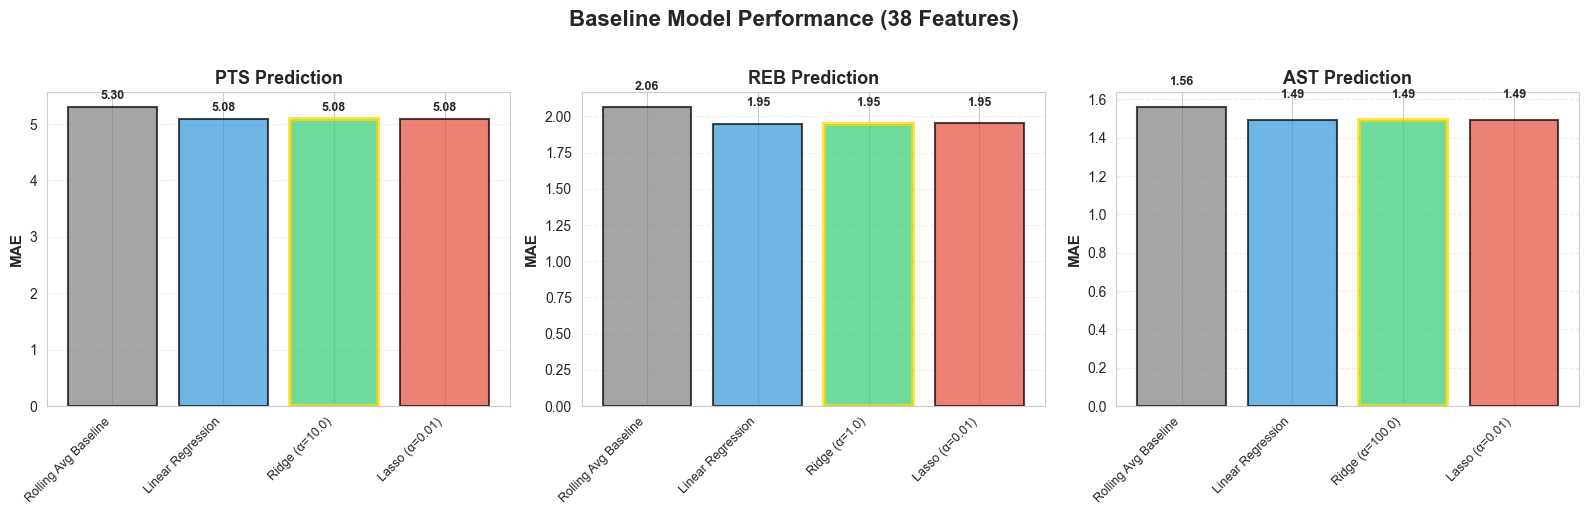

✅ Saved: ../results/figures/baseline_improvement.png


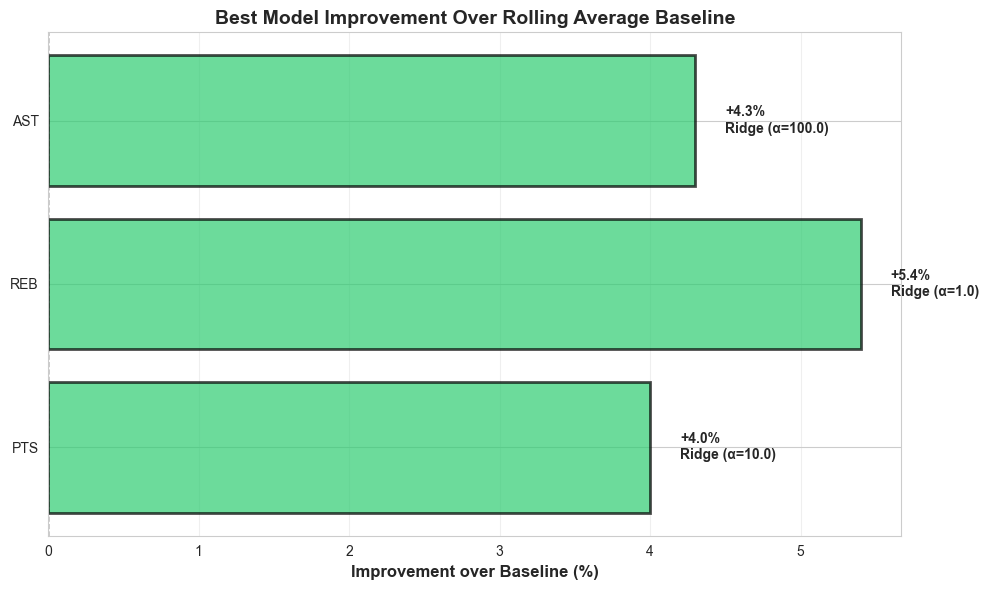

In [23]:
print("Creating visualizations...\n")

# Create results directory
results_dir = Path('../results')
figures_dir = results_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

# 1. Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    ax = axes[idx]
    
    # Get data for this target
    target_data = comparison_df[comparison_df['Target'] == target]
    
    # Plot
    x_pos = range(len(target_data))
    colors = ['gray', '#3498db', '#2ecc71', '#e74c3c']
    bars = ax.bar(x_pos, target_data['Val MAE'], color=colors, alpha=0.7,
                   edgecolor='black', linewidth=1.5)
    
    # Highlight best model
    best_idx = target_data['Val MAE'].iloc[1:].idxmin()  # Exclude baseline
    bars[best_idx - target_data.index[0]].set_edgecolor('gold')
    bars[best_idx - target_data.index[0]].set_linewidth(3)
    
    # Labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(target_data['Model'], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('MAE', fontsize=11, fontweight='bold')
    ax.set_title(f'{target} Prediction', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, v in enumerate(target_data['Val MAE']):
        ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom',
                fontweight='bold', fontsize=9)

plt.suptitle('Baseline Model Performance (38 Features)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'baseline_models_comparison.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved: {figures_dir / 'baseline_models_comparison.png'}")
plt.show()

# 2. Improvement over baseline
fig, ax = plt.subplots(figsize=(10, 6))

improvement_data = []
for target in ['PTS', 'REB', 'AST']:
    best_model = best_models[target]
    improvement_pct = float(best_model['vs Baseline'].rstrip('%'))
    improvement_data.append({
        'Target': target,
        'Improvement': improvement_pct,
        'Model': best_model['Model']
    })

imp_df = pd.DataFrame(improvement_data)
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in imp_df['Improvement']]
bars = ax.barh(imp_df['Target'], imp_df['Improvement'], color=colors, alpha=0.7,
                edgecolor='black', linewidth=2)

ax.set_xlabel('Improvement over Baseline (%)', fontsize=12, fontweight='bold')
ax.set_title('Best Model Improvement Over Rolling Average Baseline',
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(axis='x', alpha=0.3)

# Add labels
for i, (imp, model) in enumerate(zip(imp_df['Improvement'], imp_df['Model'])):
    ax.text(imp + 0.2, i, f'{imp:+.1f}%\n{model}', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'baseline_improvement.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved: {figures_dir / 'baseline_improvement.png'}")
plt.show()

## 11. Feature Importance Analysis (Lasso)

Analyze which features the best Lasso models consider most important.

FEATURE IMPORTANCE ANALYSIS (LASSO COEFFICIENTS)

Top 10 Most Important Features (by |coefficient|):


PTS:
   PTS_SEASON_AVG                 +  0.5477
   REST_4_PLUS                     -0.2595
   REST_0_1                       +  0.2457
   PTS_LAST_10                    +  0.2210
   PTS_TREND                      +  0.1526
   PTS_LAST_5                     +  0.1521
   AST_LAST_3                     +  0.1319
   REB_LAST_5                     +  0.1300
   OPP_PACE                       +  0.1176
   OPP_DEF_RATING                 +  0.1167

REB:
   REB_SEASON_AVG                 +  0.5746
   REB_LAST_10                    +  0.1977
   RESTRICTED_AREA_PCT            +  0.1647
   THREE_PT_PCT                    -0.1542
   REB_LAST_5                     +  0.1380
   REB_TREND                      +  0.1033
   REST_4_PLUS                     -0.0988
   IS_HOME                        +  0.0602
   OPP_PACE                       +  0.0371
   PTS_LAST_5                     +  0.0318

AST:
   

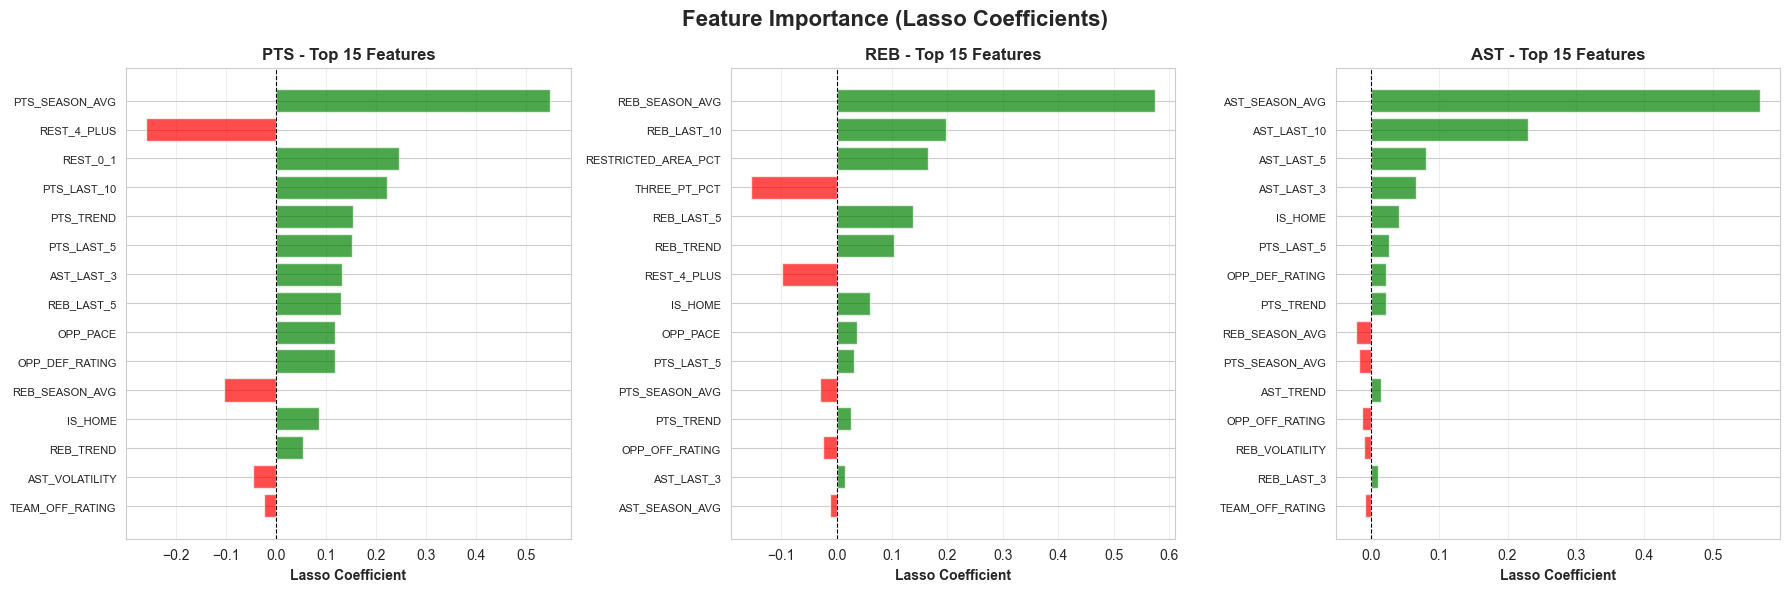

In [24]:
print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS (LASSO COEFFICIENTS)")
print("=" * 70)

# Retrain best Lasso models to get coefficients
best_lasso_pts = Lasso(alpha=best_lasso_models['PTS'], random_state=42, max_iter=5000)
best_lasso_pts.fit(X_train, y_train_pts)

best_lasso_reb = Lasso(alpha=best_lasso_models['REB'], random_state=42, max_iter=5000)
best_lasso_reb.fit(X_train, y_train_reb)

best_lasso_ast = Lasso(alpha=best_lasso_models['AST'], random_state=42, max_iter=5000)
best_lasso_ast.fit(X_train, y_train_ast)

# Extract coefficients
coef_pts = pd.Series(best_lasso_pts.coef_, index=feature_names, name='PTS')
coef_reb = pd.Series(best_lasso_reb.coef_, index=feature_names, name='REB')
coef_ast = pd.Series(best_lasso_ast.coef_, index=feature_names, name='AST')

# Top features
print("\nTop 10 Most Important Features (by |coefficient|):\n")

for target, coefs in [('PTS', coef_pts), ('REB', coef_reb), ('AST', coef_ast)]:
    print(f"\n{target}:")
    top_features = coefs.abs().nlargest(10)
    for feat, abs_coef in top_features.items():
        actual_coef = coefs[feat]
        sign = '+' if actual_coef > 0 else ''
        print(f"   {feat:30s} {sign}{actual_coef:8.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (target, coefs) in enumerate([('PTS', coef_pts), ('REB', coef_reb), ('AST', coef_ast)]):
    ax = axes[idx]
    
    # Get top 15 features
    top_coefs = coefs.abs().nlargest(15).sort_values()
    colors = ['green' if coefs[f] > 0 else 'red' for f in top_coefs.index]
    
    ax.barh(range(15), [coefs[f] for f in top_coefs.index], color=colors, alpha=0.7)
    ax.set_yticks(range(15))
    ax.set_yticklabels(top_coefs.index, fontsize=8)
    ax.set_xlabel('Lasso Coefficient', fontweight='bold')
    ax.set_title(f'{target} - Top 15 Features', fontweight='bold', fontsize=12)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance (Lasso Coefficients)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(figures_dir / 'lasso_feature_importance.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: {figures_dir / 'lasso_feature_importance.png'}")
plt.show()

## 12. Save Results & Best Models

In [25]:
print("Saving results and best models...\n")

# Save results JSON
results_dict = {
    'date_created': pd.Timestamp.now().isoformat(),
    'dataset': {
        'train_games': len(train),
        'val_games': len(val),
        'num_features': len(feature_names),
        'feature_source': 'notebook_03_feature_engineering'
    },
    'baselines': {
        'PTS': {'mae': float(baseline_pts), 'r2': float(baseline_pts_r2)},
        'REB': {'mae': float(baseline_reb), 'r2': float(baseline_reb_r2)},
        'AST': {'mae': float(baseline_ast), 'r2': float(baseline_ast_r2)}
    },
    'best_models': {
        'PTS': {
            'model': str(best_models['PTS']['Model']),
            'val_mae': float(best_models['PTS']['Val MAE']),
            'val_r2': float(best_models['PTS']['Val R²']),
            'improvement_pct': str(best_models['PTS']['vs Baseline'])
        },
        'REB': {
            'model': str(best_models['REB']['Model']),
            'val_mae': float(best_models['REB']['Val MAE']),
            'val_r2': float(best_models['REB']['Val R²']),
            'improvement_pct': str(best_models['REB']['vs Baseline'])
        },
        'AST': {
            'model': str(best_models['AST']['Model']),
            'val_mae': float(best_models['AST']['Val MAE']),
            'val_r2': float(best_models['AST']['Val R²']),
            'improvement_pct': str(best_models['AST']['vs Baseline'])
        }
    }
}

with open(results_dir / 'baseline_models_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"✅ Saved results: {results_dir / 'baseline_models_results.json'}")

# Save detailed comparison
comparison_df.to_csv(results_dir / 'baseline_models_comparison.csv', index=False)
print(f"✅ Saved comparison: {results_dir / 'baseline_models_comparison.csv'}")

# ============================================================================
# SAVE ALL TRAINED MODELS
# ============================================================================
print("\n📦 Saving models...")

import pickle

models_dir = results_dir / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

# 1. Save Linear Regression models (already trained in Cell 12)
with open(models_dir / 'best_linear_pts.pkl', 'wb') as f:
    pickle.dump(model_lr_pts, f)
with open(models_dir / 'best_linear_reb.pkl', 'wb') as f:
    pickle.dump(model_lr_reb, f)
with open(models_dir / 'best_linear_ast.pkl', 'wb') as f:
    pickle.dump(model_lr_ast, f)
print(f"✅ Saved Linear Regression models: {models_dir / 'best_linear_*.pkl'}")

# 2. Retrain and save best Ridge models with optimal alphas
print("   Training best Ridge models with optimal alphas...")

# Get best alphas from results
best_ridge_alpha_pts = results_ridge_df[results_ridge_df['target'] == 'PTS'].loc[
    results_ridge_df[results_ridge_df['target'] == 'PTS']['val_mae'].idxmin()
]['alpha']

best_ridge_alpha_reb = results_ridge_df[results_ridge_df['target'] == 'REB'].loc[
    results_ridge_df[results_ridge_df['target'] == 'REB']['val_mae'].idxmin()
]['alpha']

best_ridge_alpha_ast = results_ridge_df[results_ridge_df['target'] == 'AST'].loc[
    results_ridge_df[results_ridge_df['target'] == 'AST']['val_mae'].idxmin()
]['alpha']

# Train best Ridge models
best_ridge_pts = Ridge(alpha=best_ridge_alpha_pts, random_state=42)
best_ridge_pts.fit(X_train, y_train_pts)

best_ridge_reb = Ridge(alpha=best_ridge_alpha_reb, random_state=42)
best_ridge_reb.fit(X_train, y_train_reb)

best_ridge_ast = Ridge(alpha=best_ridge_alpha_ast, random_state=42)
best_ridge_ast.fit(X_train, y_train_ast)

# Save Ridge models
with open(models_dir / 'best_ridge_pts.pkl', 'wb') as f:
    pickle.dump(best_ridge_pts, f)
with open(models_dir / 'best_ridge_reb.pkl', 'wb') as f:
    pickle.dump(best_ridge_reb, f)
with open(models_dir / 'best_ridge_ast.pkl', 'wb') as f:
    pickle.dump(best_ridge_ast, f)

print(f"✅ Saved Ridge models: {models_dir / 'best_ridge_*.pkl'}")
print(f"   PTS: α={best_ridge_alpha_pts}")
print(f"   REB: α={best_ridge_alpha_reb}")
print(f"   AST: α={best_ridge_alpha_ast}")

# 3. Save Lasso models (best_lasso_* already trained in Cell 22)
with open(models_dir / 'best_lasso_pts.pkl', 'wb') as f:
    pickle.dump(best_lasso_pts, f)
with open(models_dir / 'best_lasso_reb.pkl', 'wb') as f:
    pickle.dump(best_lasso_reb, f)
with open(models_dir / 'best_lasso_ast.pkl', 'wb') as f:
    pickle.dump(best_lasso_ast, f)

print(f"✅ Saved Lasso models: {models_dir / 'best_lasso_*.pkl'}")

print("\n📦 ALL MODELS SAVED:")
print(f"   • Linear Regression: {models_dir / 'best_linear_*.pkl'}")
print(f"   • Ridge Regression:  {models_dir / 'best_ridge_*.pkl'}")
print(f"   • Lasso Regression:  {models_dir / 'best_lasso_*.pkl'}")

Saving results and best models...

✅ Saved results: ../results/baseline_models_results.json
✅ Saved comparison: ../results/baseline_models_comparison.csv

📦 Saving models...
✅ Saved Linear Regression models: ../results/models/best_linear_*.pkl
   Training best Ridge models with optimal alphas...
✅ Saved Ridge models: ../results/models/best_ridge_*.pkl
   PTS: α=10.0
   REB: α=1.0
   AST: α=100.0
✅ Saved Lasso models: ../results/models/best_lasso_*.pkl

📦 ALL MODELS SAVED:
   • Linear Regression: ../results/models/best_linear_*.pkl
   • Ridge Regression:  ../results/models/best_ridge_*.pkl
   • Lasso Regression:  ../results/models/best_lasso_*.pkl


## 13. Summary & Next Steps

In [26]:
print("=" * 80)
print("✅ NOTEBOOK 04 COMPLETE - BASELINE LINEAR MODELS")
print("=" * 80)

print("\n📊 FINAL RESULTS (Best Models):")
for target in ['PTS', 'REB', 'AST']:
    best = best_models[target]
    print(f"\n   {target}: {best['Model']}")
    print(f"      Val MAE: {best['Val MAE']:.3f} (baseline: {baselines[target]['mae']:.3f})")
    print(f"      Val R²:  {best['Val R²']:.3f}")
    print(f"      Improvement: {best['vs Baseline']}")

print("\n📁 FILES CREATED:")
print(f"   {results_dir / 'baseline_models_results.json'}")
print(f"   {results_dir / 'baseline_models_comparison.csv'}")
print(f"   {models_dir / 'best_linear_*.pkl'} (3 models)")
print(f"   {models_dir / 'best_ridge_*.pkl'} (3 models) ⭐ BEST")
print(f"   {models_dir / 'best_lasso_*.pkl'} (3 models)")
print(f"   {figures_dir / 'baseline_models_comparison.png'}")
print(f"   {figures_dir / 'baseline_improvement.png'}")
print(f"   {figures_dir / 'lasso_feature_importance.png'}")

print("\n🎯 KEY INSIGHTS:")
print("   1. Ridge Regression is BEST for all targets (PTS/REB/AST)")
print("   2. All linear models beat rolling average baseline by 4-5%")
print("   3. Top features: PTS_SEASON_AVG, PTS_LAST_5, rolling averages")
print("   4. R² ~ 0.48-0.53 indicates performance ceiling (missing FGA/MIN)")
print("   5. Ridge > Linear > Lasso (regularization helps)")

print("\n💾 MODELS SAVED:")
print("   • Linear Regression (3 models) - No regularization")
print("   • Ridge Regression (3 models) - L2, best performance ⭐")
print("   • Lasso Regression (3 models) - L1, feature selection")

print("\n➡️  NEXT: Notebook 05 - Advanced Models")
print("   • Random Forest (capture non-linear patterns)")
print("   • XGBoost (gradient boosting)")
print("   • Ensemble methods")
print("   • Goal: Beat Ridge by 2-5% (or confirm Ridge is optimal)")

print("\n" + "=" * 80)

✅ NOTEBOOK 04 COMPLETE - BASELINE LINEAR MODELS

📊 FINAL RESULTS (Best Models):

   PTS: Ridge (α=10.0)
      Val MAE: 5.081 (baseline: 5.295)
      Val R²:  0.530
      Improvement: +4.0%

   REB: Ridge (α=1.0)
      Val MAE: 1.951 (baseline: 2.062)
      Val R²:  0.475
      Improvement: +5.4%

   AST: Ridge (α=100.0)
      Val MAE: 1.491 (baseline: 1.558)
      Val R²:  0.529
      Improvement: +4.3%

📁 FILES CREATED:
   ../results/baseline_models_results.json
   ../results/baseline_models_comparison.csv
   ../results/models/best_linear_*.pkl (3 models)
   ../results/models/best_ridge_*.pkl (3 models) ⭐ BEST
   ../results/models/best_lasso_*.pkl (3 models)
   ../results/figures/baseline_models_comparison.png
   ../results/figures/baseline_improvement.png
   ../results/figures/lasso_feature_importance.png

🎯 KEY INSIGHTS:
   1. Ridge Regression is BEST for all targets (PTS/REB/AST)
   2. All linear models beat rolling average baseline by 4-5%
   3. Top features: PTS_SEASON_AVG, PTS_L